# SOBOL Analysis
In this section, we will analyze our model sensitivity by performing a SOBOL analysis. This is an easy to use and accurate method to gain insights in what uncertainties are most important to our model. We will use the SALib library to perform the analysis.

In [1]:
# Importing the necessary packages
from ema_workbench import (Model, Policy, ema_logging, SequentialEvaluator, 
                           MultiprocessingEvaluator, Samplers)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from SALib.analyze.sobol import analyze
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dike_model_function import DikeNetwork
from custom_problem_formulation import get_model_for_problem_formulation

# Setting logging
ema_logging.log_to_stderr(ema_logging.INFO)

/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


<Logger EMA (DEBUG)>

To be able to analyse the effect of uncertainties on our outcomes of interest, we run SOBOL without any policies in place. This way we capture the 'pure' effect of all uncertainties

In [3]:
# Setting problem formulation and number of scenarios
dike_model, planning_steps = get_model_for_problem_formulation()

n_scenarios = 1000

# Setting policies to zero
policies= [Policy("No Policy", **dict({l.name: 0 for l in dike_model.levers}))]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies=policies, uncertainty_sampling=Samplers.SOBOL)

experiments, outcomes = results
problem = get_SALib_problem(dike_model.uncertainties)

/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decis

The next step is to visualise these results. This allows us to visually inspect the effect of different uncertainties on different outcomes of interest. Our outcomes of interest are the following:
- A.1_External Costs
- A.2_External Costs
- A.1_Expected number of deaths
- A.2_Expected number of deaths
- A.1_Expected number of annual damage
- A.2_Expected number of annual damage

Initially we also wanted to inspect 'A.1_RfR Costs' and 'A.2_RfR Costs', however at a later stage in the analysis we found out that we made a mistake in our custom_problem_formulation.py, leading to the RfR Costs not being properly recorded. Due to the late phase in which we discovered this (leaving us with too little time to rerun all experiments with a new and improved custom_problem_formulation), and combined with the fact that the way we operationalised the problem for our stakeholder RfR Costs aren't a big interest, we won't discuss these any further. This also had consequences at other points in the analysis, which will be mentioned at those specific points in the analysis.

In [4]:
# Set up a function to visualize the results
def plot_sobol_effects(problem, outcome_name, indices_data, confidence_intervals=None):
  """
  Plots Sobol effects (S1, ST) with optional confidence intervals.

  Args:
      problem: Dictionary containing problem information (assuming "names" key for variable names).
      outcome_name: The name of the outcome variable.
      indices_data: A dictionary containing S1, ST, and optionally S1_conf, ST_conf values.
      confidence_intervals: A boolean flag indicating if confidence intervals should be plotted (default: None).
  """
  variable_names = problem["names"]
  indices_df = pd.DataFrame(indices_data, index=variable_names)

  indices = indices_df[["S1", "ST"]]
  err = None if confidence_intervals is None else indices_df[["S1_conf", "ST_conf"]]

  fig, ax = plt.subplots(figsize=(8, 6))

  indices.plot.bar(yerr=err.values.T, ax=ax)

  # Graph setup
  plt.title(f'SOBOL on {outcome_name}')
  plt.xlabel('Uncertainties')
  plt.ylabel(f'{outcome_name}')
  plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
  plt.tight_layout()
  plt.savefig(f'./images/SOBOL_{outcome_name}.png')  # Dynamic filename based on outcome
  plt.show()


/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/SALib/analyze/sobol.py:145: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


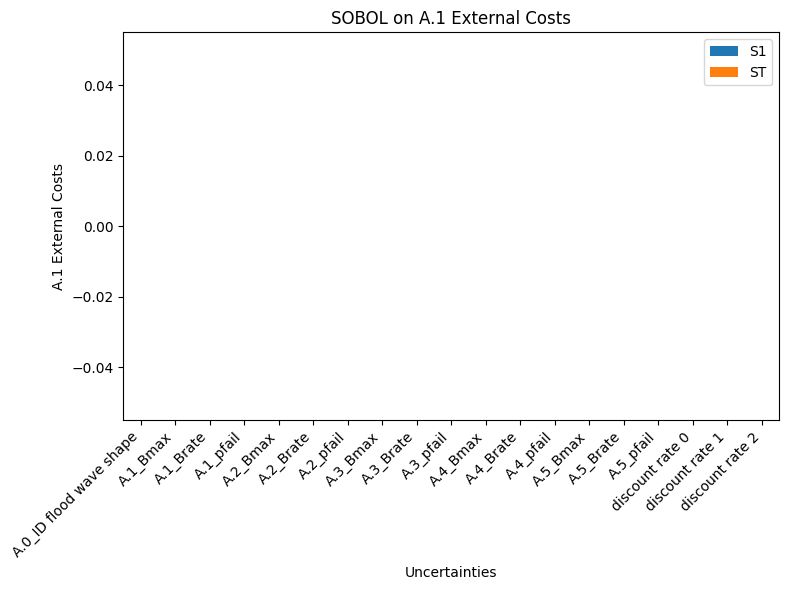

In [6]:
y = outcomes["A.1_External Costs"]
indices = analyze(problem, y, calc_second_order=True, print_to_console=False)

# Filter relevant Sobol indices, we look at the total effects (ST) and first-order effects (S1)
scores_filtered = {"S1": indices["S1"], "ST": indices["ST"],
                   "S1_conf": indices.get("S1_conf", None),  # Include confidence intervals if available
                   "ST_conf": indices.get("ST_conf", None)} 

plot_sobol_effects(problem, "A.1 External Costs", scores_filtered, confidence_intervals=True)

As can be seen, there are no uncertainties that affect A.1_External Costs. This makes sense, as in custom_problem_formulation.py we define 'External Costs' as the sum of 'Expected Evacuation Costs' and 'Dike Investment Costs'. Given that this SOBOL is performed with all policies set to zero, and 'Expected Evacuation Costs' and 'Dike Investment Costs' would only occur when implementing certain policies it's logical that there are no uncertainties that have an effect on this. 

/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/SALib/analyze/sobol.py:145: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


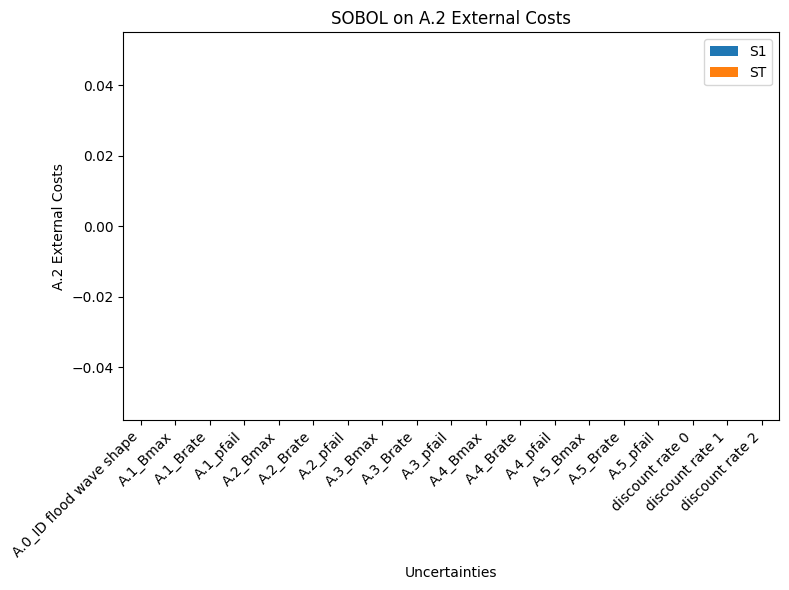

In [7]:
y = outcomes["A.2_External Costs"]
indices = analyze(problem, y, calc_second_order=True, print_to_console=False)

# Filter relevant Sobol indices, we look at the total effects (ST) and first-order effects (S1)
scores_filtered = {"S1": indices["S1"], "ST": indices["ST"],
                   "S1_conf": indices.get("S1_conf", None),  # Include confidence intervals if available
                   "ST_conf": indices.get("ST_conf", None)} 

plot_sobol_effects(problem, "A.2 External Costs", scores_filtered, confidence_intervals=True)

Just like for A.1_External Costs, there are no uncertainties that affect A.2_External Costs. This is for the same exact reason, and thus makes sense.

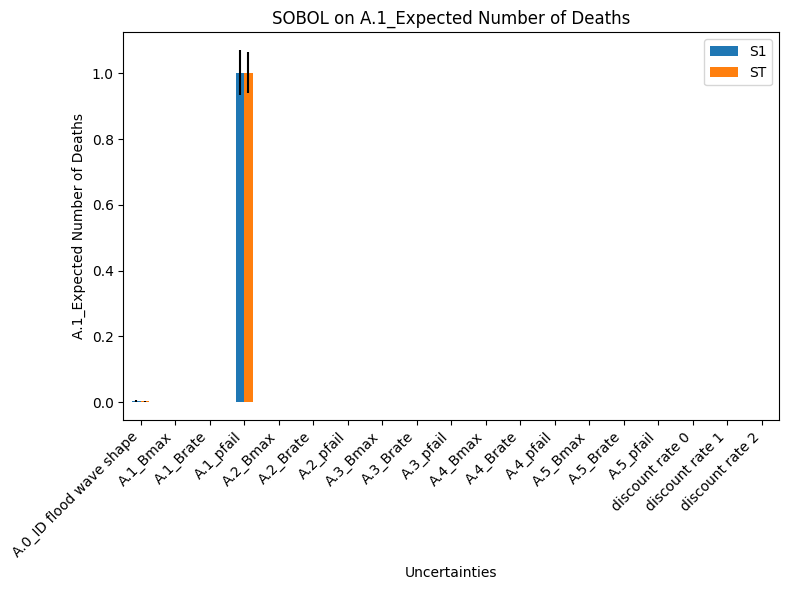

In [8]:
y = outcomes["A.1_Expected Number of Deaths"]
indices = analyze(problem, y, calc_second_order=True, print_to_console=False)

# Filter relevant Sobol indices, we look at the total effects (ST) and first-order effects (S1)
scores_filtered = {"S1": indices["S1"], "ST": indices["ST"],
                   "S1_conf": indices.get("S1_conf", None),  # Include confidence intervals if available
                   "ST_conf": indices.get("ST_conf", None)} 

plot_sobol_effects(problem, "A.1_Expected Number of Deaths", scores_filtered, confidence_intervals=True)

This shows that A.1_Expected Number of Deaths is affected by almost only A.1_pfail. It makes sense that this isn't affected by any variables from A.2 up until A.5, as A.1 is the most upstream dike ring and thus doesn't suffere consequences from anything happening downstream. However, conceptually we would have expected A.1_Bmax to also have an affect, as this ultimately dictates how severe the flooding is. This not being the case might just be a result from how the model works.

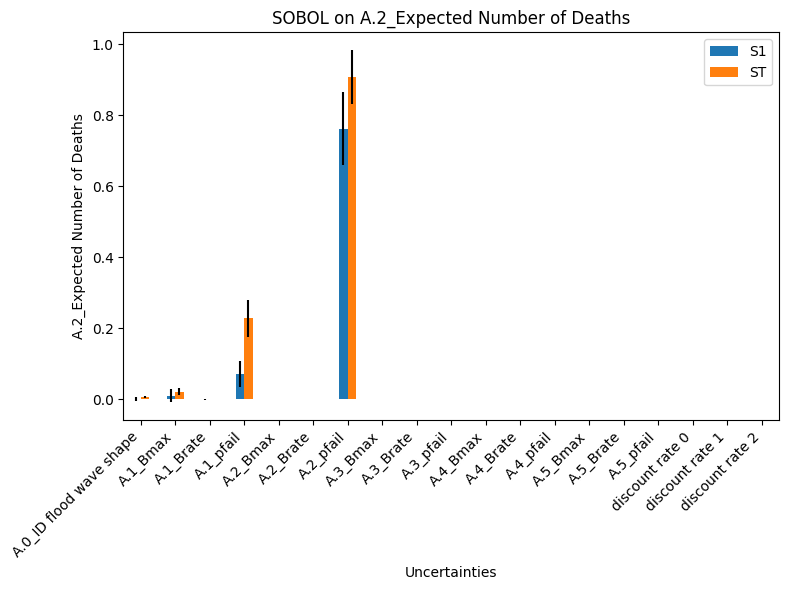

In [9]:
y = outcomes["A.2_Expected Number of Deaths"]
indices = analyze(problem, y, calc_second_order=True, print_to_console=False)

# Filter relevant Sobol indices, we look at the total effects (ST) and first-order effects (S1)
scores_filtered = {"S1": indices["S1"], "ST": indices["ST"],
                   "S1_conf": indices.get("S1_conf", None),  # Include confidence intervals if available
                   "ST_conf": indices.get("ST_conf", None)} 

plot_sobol_effects(problem, "A.2_Expected Number of Deaths", scores_filtered, confidence_intervals=True)

This shows that A.2_Expected Number of Deaths is mainly affected by A.2_pfail, which makes sense. Again it also makes sense that this isn't affected by any variables from A.3 up until A.5, as these variables only have effect further downstream. We also see some effect of A.1_pfail, this is logical given the fact that this is upstream from A.2, so A.1 dikes failing, or not, will have an effect on A.2.

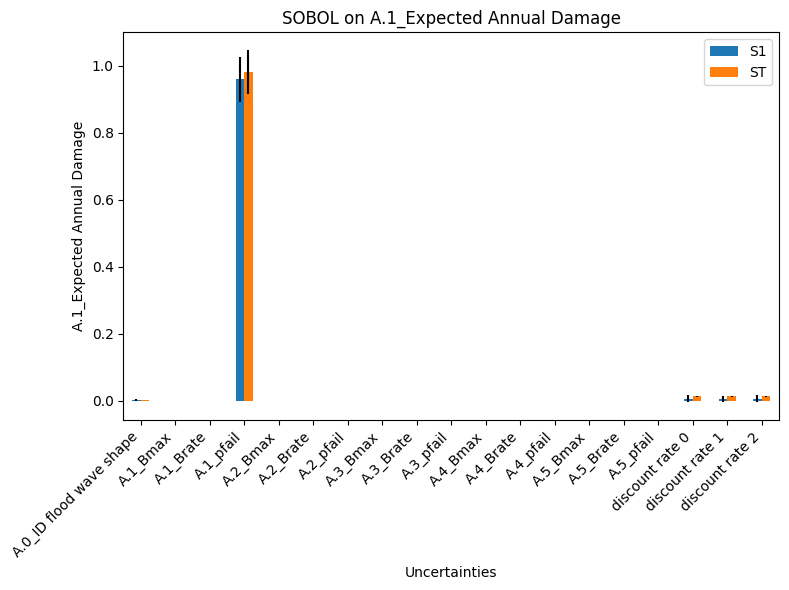

In [10]:
y = outcomes["A.1_Expected Annual Damage"]
indices = analyze(problem, y, calc_second_order=True, print_to_console=False)

# Filter relevant Sobol indices, we look at the total effects (ST) and first-order effects (S1)
scores_filtered = {"S1": indices["S1"], "ST": indices["ST"],
                   "S1_conf": indices.get("S1_conf", None),  # Include confidence intervals if available
                   "ST_conf": indices.get("ST_conf", None)} 

plot_sobol_effects(problem, "A.1_Expected Annual Damage", scores_filtered, confidence_intervals=True)

What we see in the graph above is due to the same reasons as mentioned in the graph for A.1_Expected Number of Deaths. Addiotionally we see a slight effect of the discount rates. This makes sense as the amount of annual damage in the future is affected by if, and what, discount rate is used.

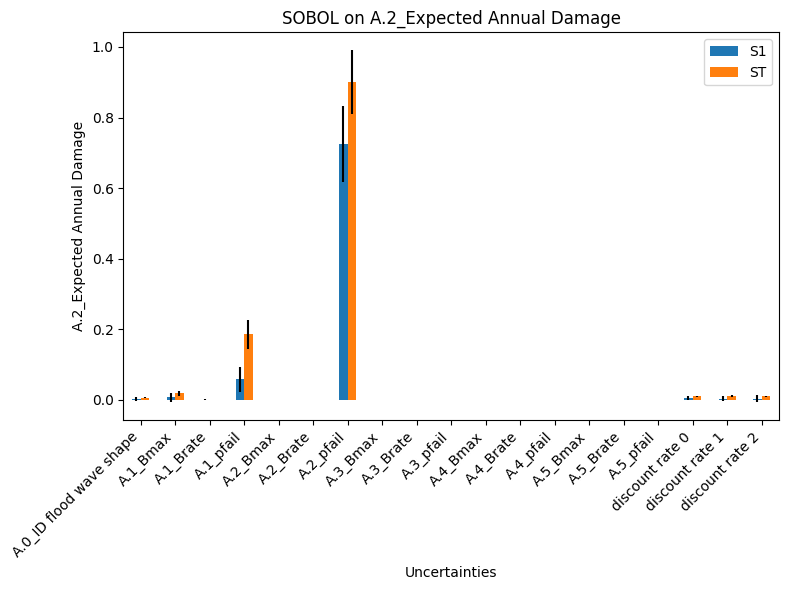

In [11]:
y = outcomes["A.2_Expected Annual Damage"]
indices = analyze(problem, y, calc_second_order=True, print_to_console=False)

# Filter relevant Sobol indices, we look at the total effects (ST) and first-order effects (S1)
scores_filtered = {"S1": indices["S1"], "ST": indices["ST"],
                   "S1_conf": indices.get("S1_conf", None),  # Include confidence intervals if available
                   "ST_conf": indices.get("ST_conf", None)} 

plot_sobol_effects(problem, "A.2_Expected Annual Damage", scores_filtered, confidence_intervals=True)

The results in the graph above are due to the same reasons as for A.1_Expected Annual Damage, and as mentioned for A.2 we also see some influence of A.1 uncertainties as these are upstream. 